In [ ]:
# connecting to drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# file path
file_path = "/content/drive/MyDrive/ColabNotebooks/AAPL_2012-06-21_34200000_57600000_orderbook_1.csv"

df = pd.read_csv(file_path, header=None)

df = df.dropna()

df.columns = ["ask_price", "ask_size", "bid_price", "bid_size"]

df["ask_price"] = df["ask_price"] / 10000.0
df["bid_price"] = df["bid_price"] / 10000.0

df = df[
    (df["ask_price"] > df["bid_price"]) &
    (df["ask_size"] > 0) &
    (df["bid_size"] > 0)
]

# calculating mid-price
df["mid"] = (df["ask_price"] + df["bid_price"]) / 2

print("Data is loaded!")
print("Example:")
print(df.head())
print("\nTotal records:", len(df))

In [2]:
df = df.reset_index(drop=True)

df["next_mid"] = np.nan

n = len(df)
if n == 0:
    raise ValueError("Data is null!")

# initiating last value
last_mid = df.loc[n - 1, "mid"]
df.loc[n - 1, "next_mid"] = last_mid

# going in reverse and remembering the last mid value
for i in range(n - 2, -1, -1):
    current_mid = df.loc[i, "mid"]
    if current_mid != df.loc[i + 1, "mid"]:
        last_mid = df.loc[i + 1, "mid"]
    df.loc[i, "next_mid"] = last_mid

# 1 = up, 0 = down
df["direction"] = np.where(df["next_mid"] > df["mid"], 1,
                  np.where(df["next_mid"] < df["mid"], 0, np.nan))

# deleting rows with no direction
df = df.dropna(subset=["direction"])
df["direction"] = df["direction"].astype(int)

print("Directions are set!")
print("Example:")
print(df[["mid", "next_mid", "direction"]].head(10))
print("\nTotal directions:", len(df))

✅ Направления определены!
Пример:
       mid  next_mid  direction
0  585.635   585.620          0
1  585.620   585.625          1
2  585.625   585.630          1
3  585.630   585.645          1
4  585.645   585.830          1
5  585.830   585.735          0
6  585.735   585.740          1
7  585.740   585.755          1
8  585.740   585.755          1
9  585.740   585.755          1

Всего наблюдений с направлением: 118495


In [3]:
# Breaking down the sizes by (1–10)
df["bid_decile"] = pd.qcut(df["bid_size"], 10, labels=False, duplicates='drop') + 1
df["ask_decile"] = pd.qcut(df["ask_size"], 10, labels=False, duplicates='drop') + 1

# Grouping and summing
grouped = df.groupby(["bid_decile", "ask_decile"])["direction"].agg(
    up_prob="mean",
    count="size"
).reset_index()

print("Empirical probabilities:")
print(grouped.head(10))

✅ Эмпирические вероятности посчитаны!
   bid_decile  ask_decile   up_prob  count
0           1           1  0.509171   1581
1           1           2  0.502744   1822
2           1           3  0.468755   6833
3           1           4  0.389111   1249
4           1           5  0.406972   2467
5           1           6  0.343450    626
6           1           7  0.418975   1444
7           2           1  0.493028   1004
8           2           2  0.428408    873
9           2           3  0.457678   3686


In [4]:
from scipy.optimize import minimize_scalar

def loss(H, grouped):
    pred = (grouped["bid_decile"] + H) / (grouped["bid_decile"] + grouped["ask_decile"] + 2 * H)
    error = (grouped["up_prob"] - pred) ** 2
    return np.sum(error * grouped["count"])

# Minimalization
res = minimize_scalar(loss, bounds=(0, 10), args=(grouped,), method='bounded')
H_opt = res.x

print(f"\nHidden liquidity H = {H_opt:.3f}")


🎯 Оценка скрытой ликвидности H = 8.672


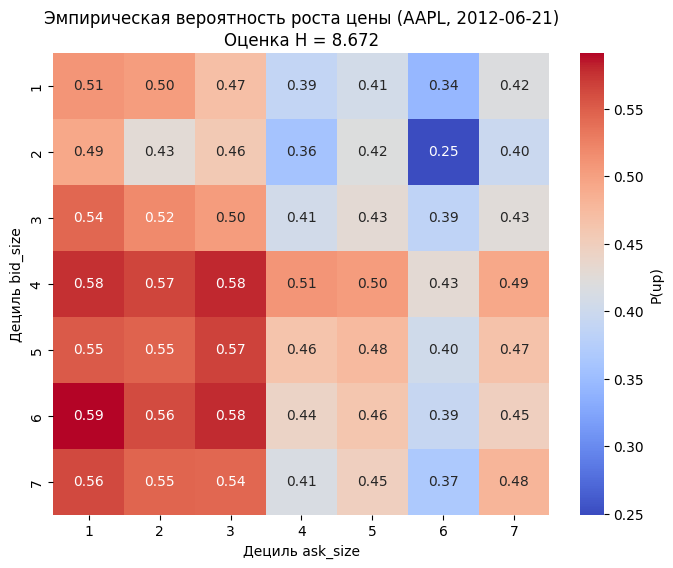

In [6]:

import seaborn as sns
import matplotlib.pyplot as plt

# pivot table for the heatmap
heatmap_data = grouped.pivot(index="bid_decile", columns="ask_decile", values="up_prob")

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'P(up)'})
plt.title(f"Empirical probability of price going up (AAPL, 2012-06-21)\n H = {H_opt:.3f}")
plt.xlabel("ask_size")
plt.ylabel("bid_size")
plt.show()

In [7]:
# Calculating the probability if H=0
grouped["pred_H0"] = grouped["bid_decile"] / (grouped["bid_decile"] + grouped["ask_decile"])

# MSE while H=0
mse_H0 = np.average(
    (grouped["up_prob"] - grouped["pred_H0"])**2,
    weights=grouped["count"]
)

print(f"MSE while H=0: {mse_H0:.6f}")

# Comparing to MSE H=0.1
grouped["pred_H01"] = (grouped["bid_decile"] + 0.1) / (grouped["bid_decile"] + grouped["ask_decile"] + 0.2)
mse_H01 = np.average(
    (grouped["up_prob"] - grouped["pred_H01"])**2,
    weights=grouped["count"]
)
print(f"MSE while H=0.1: {mse_H01:.6f}")

MSE при H=0: 0.016927
MSE при H=0.1: 0.015550


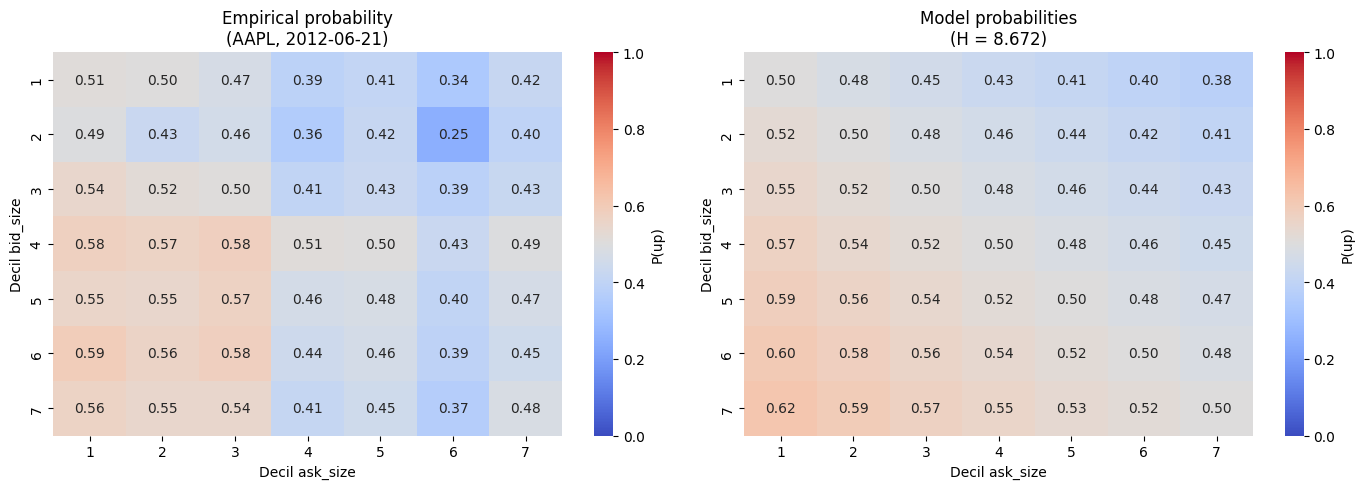

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# model probability p(i,j;H) = (i + H) / (i + j + 2H)
grouped["model_prob"] = (grouped["bid_decile"] + H_opt) / (grouped["bid_decile"] + grouped["ask_decile"] + 2 * H_opt)

# pivot-tables for the heatmap
empirical_heatmap = grouped.pivot(index="bid_decile", columns="ask_decile", values="up_prob")
model_heatmap = grouped.pivot(index="bid_decile", columns="ask_decile", values="model_prob")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(
    empirical_heatmap,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    cbar_kws={'label': 'P(up)'},
    ax=axes[0]
)
axes[0].set_title(f"Empirical probability\n(AAPL, 2012-06-21)")
axes[0].set_xlabel("Decil ask_size")
axes[0].set_ylabel("Decil bid_size")

sns.heatmap(
    model_heatmap,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=0.0,
    vmax=1.0,
    cbar_kws={'label': 'P(up)'},
    ax=axes[1]
)
axes[1].set_title(f"Model probabilities\n(H = {H_opt:.3f})")
axes[1].set_xlabel("Decil ask_size")
axes[1].set_ylabel("Decil bid_size")

plt.tight_layout()
plt.show()

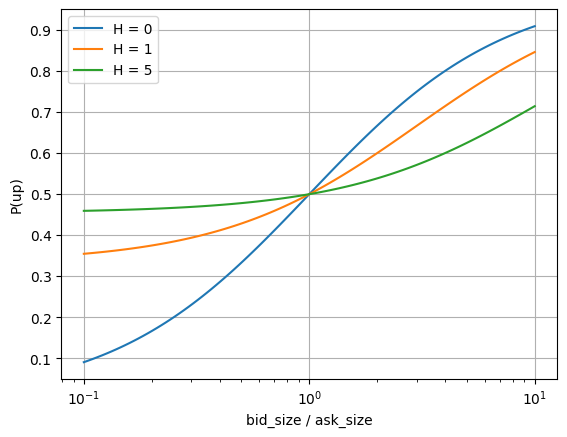

In [1]:
import numpy as np
import matplotlib.pyplot as plt
x = np.logspace(-1, 1, 100)
for H in [0, 1, 5]:
    p = (x + H) / (x + 1 + 2*H)
    plt.plot(x, p, label=f'H = {H}')
plt.xscale('log')
plt.xlabel('bid_size / ask_size')
plt.ylabel('P(up)')
plt.legend()
plt.grid(True)